In [27]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
import pandas as pd
import os
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.model_selection import train_test_split
from scipy.io import arff

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
import boto3
import os
from sklearn.model_selection import train_test_split

In [29]:
s3 = boto3.resource('s3')
bucket = "humana-transportation"
prefix = "xgboost"

In [20]:
pca_df = pd.read_csv("pca_train.csv", low_memory = False)

X_train, X_test, y_train, y_test = train_test_split(pca_df.iloc[:,1:], pca_df.iloc[:,0], 
                                                    test_size=0.4, random_state=42, stratify = pca_df.iloc[:,0])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    test_size=0.5, random_state=42, stratify = y_test)

print(f'Shape of train {X_train.shape} \n Shape of validate {X_val.shape} \n Shape of test {X_test.shape}')

In [58]:
train_file='train.csv'
test_file='test.csv'
# validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
# upload_s3_csv(validate_file, 'validate', validate)

In [59]:
container = get_image_uri(boto3.Session().region_name,'xgboost','0.90-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic",
             "silent" : 1}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       train_instance_count=1,
                                       train_instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                         sagemaker_session=sagemaker.Session())

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [60]:
                                      
train_channel = sagemaker.session.s3_input(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.session.s3_input(
    "s3://{}/{}/test/".format(bucket,prefix,test_file),
    content_type='text/csv')

xgb_model.fit({'train': train_channel,'validation': validate_channel})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-08 01:01:14 Starting - Starting the training job...
2020-10-08 01:01:17 Starting - Launching requested ML instances......
2020-10-08 01:02:20 Starting - Preparing the instances for training...
2020-10-08 01:03:08 Downloading - Downloading input data...
2020-10-08 01:03:31 Training - Downloading the training image...
2020-10-08 01:04:16 Uploading - Uploading generated training model
2020-10-08 01:04:16 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined

In [61]:
batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


.....................................................!


In [62]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]


In [63]:
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

Sensitivity or TPR: 11.69085916045508%
Specificity or TNR: 97.74993263271355%
Precision: 47.151898734177216%
Negative Predictive Value: 86.57001372233161%
False Positive Rate: 2.2500673672864457%
False Negative Rate: 88.30914083954492%
False Discovery Rate: 52.84810126582279%
Accuracy: 85.13769907434026%
Validation AUC 0.5472039589658432
Figure(432x288)


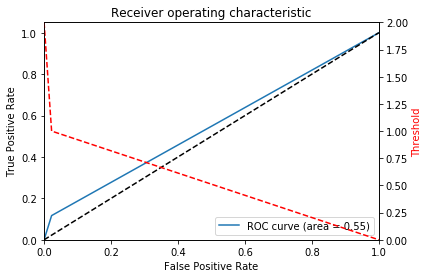

<Figure size 432x288 with 0 Axes>

In [64]:
plot_roc(test_labels, target_predicted_binary)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:auc'
objective_type = 'Maximize'

tuner = HyperparameterTuner(xgb_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit({'train': train_channel,'validation': validate_channel})
tuner.wait()

..........................................................................................................................................................................................................................................................................................................!


In [68]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [69]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics 
df_tuning_job_analytics.head()

# Best hyperparameters are used for the final model

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,69.227884,0.209479,3.279315,50.0,0.872489,sagemaker-xgboost-201008-0130-010-80db45ad,Completed,0.731801,2020-10-08 02:04:35+00:00,2020-10-08 02:05:53+00:00,78.0
3,88.504739,0.263263,3.608827,40.0,0.611441,sagemaker-xgboost-201008-0130-007-b862307f,Completed,0.729259,2020-10-08 01:53:36+00:00,2020-10-08 01:54:45+00:00,69.0
9,12.505838,0.176015,4.872904,32.0,0.970470,sagemaker-xgboost-201008-0130-001-6e978899,Completed,0.728863,2020-10-08 01:32:52+00:00,2020-10-08 01:33:51+00:00,59.0
4,90.504739,0.263263,3.528827,43.0,0.611441,sagemaker-xgboost-201008-0130-006-1b615238,Completed,0.728821,2020-10-08 01:50:17+00:00,2020-10-08 01:51:25+00:00,68.0
6,5.451150,0.290906,4.295717,22.0,0.995978,sagemaker-xgboost-201008-0130-004-5e8ec6f2,Completed,0.724899,2020-10-08 01:42:56+00:00,2020-10-08 01:43:48+00:00,52.0
8,73.601053,0.227405,1.281635,15.0,0.995917,sagemaker-xgboost-201008-0130-002-e3bfbb12,Completed,0.720206,2020-10-08 01:36:07+00:00,2020-10-08 01:37:15+00:00,68.0
1,93.671365,0.101139,1.195697,40.0,0.506659,sagemaker-xgboost-201008-0130-009-a47a1f24,Completed,0.720052,2020-10-08 02:01:04+00:00,2020-10-08 02:02:01+00:00,57.0
5,5.448099,0.264337,3.694843,20.0,0.516725,sagemaker-xgboost-201008-0130-005-1cb9e639,Completed,0.718162,2020-10-08 01:46:23+00:00,2020-10-08 01:47:36+00:00,73.0
7,58.830545,0.141086,4.606752,9.0,0.894477,sagemaker-xgboost-201008-0130-003-8faa3202,Completed,0.703834,2020-10-08 01:39:41+00:00,2020-10-08 01:40:31+00:00,50.0
2,24.985558,0.290948,4.799257,1.0,0.630616,sagemaker-xgboost-201008-0130-008-e05a89f7,Completed,0.663949,2020-10-08 01:57:11+00:00,2020-10-08 01:58:10+00:00,59.0
